# Data driven prediction of battery cycle life before capacity degradation

Paper:

[Severson, K.A., Attia, P.M., Jin, N. et al. Data-driven prediction of battery cycle life before capacity degradation. Nat Energy 4, 383–391 (2019)](https://www.nature.com/articles/s41560-019-0356-8)


Raw Data:

[Experimental Data Platform (matr.io))](https://data.matr.io/1/projects/5c48dd2bc625d700019f3204)


## Structure of this Notebook
- Read datasets from files into lists
- Reproduce figures
- Reproduce the three elastic net ML models

## Import packages and modules

In [1]:
import pathlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os, random
import numpy as np
import statistics
from functions import get_errors

## Create a list containing the summary data (per cycle) for each cell

In [2]:
summary = []
directory = r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\data\interim\summary"
for filename in os.listdir(directory):
    f = os.path.join(directory,filename)
    summary.append(pd.read_csv(f))

In [3]:
len(summary)

137

## Create a lists containing
- the $\Delta Q_{100-10}(V)$ values
- cycle 10 discharge data
- cycle 100 discharge data

In [4]:
DeltaQ100_10 = []
c10_discharge = []
c100_discharge = []
directory1 = r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\data\interim\cycles_interpolated\DeltaQ100_10_discharge"
directory2 = r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\data\interim\cycles_interpolated\cycle10_discharge"
directory3 = r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\data\interim\cycles_interpolated\cycle100_discharge"
for filename in os.listdir(directory1):
    f1 = os.path.join(directory1,filename)
    DeltaQ100_10.append(pd.read_csv(f1))
    
for filename in os.listdir(directory2):
    f2 = os.path.join(directory2,filename)
    c10_discharge.append(pd.read_csv(f2))
    
for filename in os.listdir(directory3):
    f3 = os.path.join(directory3,filename)
    c100_discharge.append(pd.read_csv(f3))

print(len(DeltaQ100_10))
print(len(c10_discharge))
print(len(c100_discharge))

137
137
137


#### Overview of data in summary

In [5]:
summary[10].head(3)

,cycle_index,discharge_capacity,charge_capacity,discharge_energy,charge_energy,dc_internal_resistance,temperature_maximum,temperature_average,temperature_minimum,date_time_iso,energy_efficiency,charge_throughput,energy_throughput,charge_duration,time_temperature_integrated,paused
0,0,1.563987,1.066702,4.785489,3.720086,0.016289,36.226662,31.508545,23.500174,2018-04-13T01:27:28+00:00,1.286392,1.066702,3.720086,101632.0,53843.860640,0
1,1,1.069167,1.068464,3.250850,3.710386,0.016046,36.368675,33.560314,30.795448,2018-04-14T06:24:00+00:00,0.876149,2.135166,7.430472,512.0,1641.662223,0
2,2,1.070185,1.069661,3.256119,3.710983,0.015844,36.844353,33.759354,30.908312,2018-04-14T07:13:04+00:00,0.877428,3.204827,11.141455,512.0,1582.717554,0


#### Overview of data in cycle 10 discharge (same for cycle 100)

In [6]:
c10_discharge[10].head(3)

,cycle_index,discharge_capacity,charge_capacity,voltage,internal_resistance,temperature,current,step_type,cycle_life
0,9,0.996691,1.07224,2.800000,0.015931,35.622414,-4.400020,discharge,1046
1,9,0.996478,1.07224,2.800701,0.015931,35.620228,-4.400031,discharge,1046
2,9,0.996264,1.07224,2.801401,0.015931,35.618042,-4.400043,discharge,1046


#### Overview of $\Delta Q_{100-10}(V)$ data

In [7]:
DeltaQ100_10[10].head(3)

,discharge_capacity,cycle_life
0,-0.015909,1046
1,-0.015916,1046
2,-0.015923,1046


# Figures From Severson et al

#### First make colormap sorting all cells according to cycle life
- Creates an array of RGB colors from blue to red, where red is short cycle life and blue is long

In [8]:
from matplotlib.colors import LinearSegmentedColormap

cl = []
for cell in summary:
    cl.append(cell.index[-1])
    
cl = np.array(cl)
cl = np.sort(cl)[::-1]
cl_norm = minmax_scale(cl)

colormap = mpl.cm.ScalarMappable(cmap='RdBu_r')
colors = colormap.to_rgba(cl_norm)

In [9]:
len(colors)

137

#### Fig 1a: Discharge capacity fade curves for the first 1000 cycles

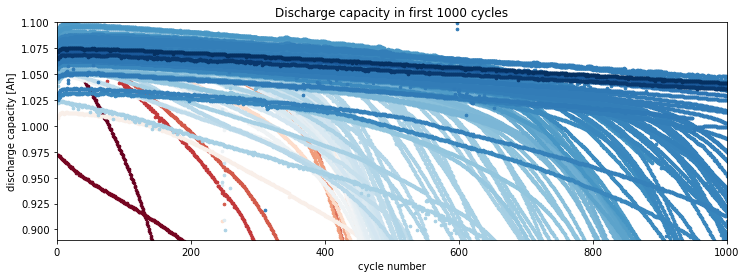

In [91]:
# Sort cells according to cycle life
summary_sorted = sorted(summary, key=lambda x:x.index[-1])
Qd_ratios = []

# Plot
fig, ax = plt.subplots(figsize=(12,4))
i = 0
for cell in summary_sorted:
    Qd = cell['discharge_capacity'][1:-1] # First and last value is way higher for some reason so they are not included
    cycles = cell.index[1:-1]
    ax.scatter(cycles, Qd, s=7, color=colors[i])
    ax.set_xlabel('cycle number')
    ax.set_ylabel('discharge capacity [Ah]')
    ax.set_xlim(0,1000)
    ax.set_ylim(0.89,1.1)
    ax.set_title("Discharge capacity in first 1000 cycles")

    Qd_ratios.append(float(cell['discharge_capacity'][99]/cell['discharge_capacity'][1]))

    i += 1

fig.savefig(".\out\capacity_fade.png")

#### Fig 1b: Discharge capacity fade curve for only the first 100 cycles

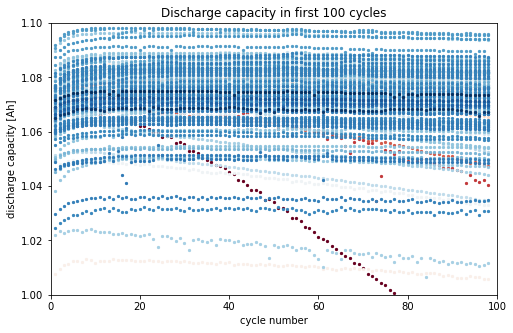

In [92]:
fig, ax = plt.subplots(figsize=(8,5))
i = 0
for cell in summary_sorted:
    Qd100 = cell['discharge_capacity'][1:99]
    cycles = cell.index[1:99]
    ax.scatter(cycles, Qd100, s=5, color=colors[i])
    ax.set_xlabel('cycle number')
    ax.set_ylabel('discharge capacity [Ah]')
    ax.set_xlim(0,100)
    ax.set_ylim(1,1.1)
    ax.set_title("Discharge capacity in first 100 cycles")
    
    i += 1
fig.savefig(".\out\capacity_fade_closeup.png")

#### Fig 1c: Qd ratios between 2 and 100 showing that the capacity initially increases for most cells

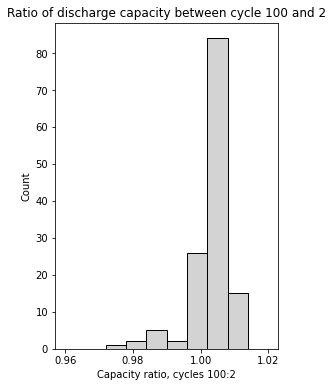

In [93]:
fig, ax = plt.subplots(figsize=(4,6))
ax.hist(Qd_ratios, range=(0.96,1.02), color='lightgrey', edgecolor='black')
ax.set_xticks([0.96, 0.98, 1.00, 1.02])
ax.set_xlabel('Capacity ratio, cycles 100:2')
ax.set_ylabel('Count', rotation=('vertical'))
ax.set_title('Ratio of discharge capacity between cycle 100 and 2')
fig.savefig(".\out\capacity_ratios.png")

#### Fig 1d-f showing weak linear correlation between the log of cycle life and discharge capacity at cycle 2, 100 and 95-100.

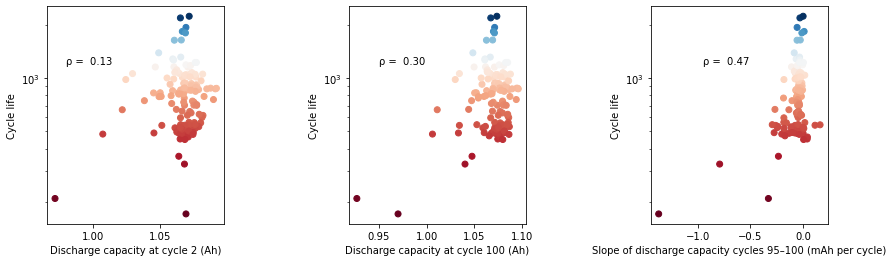

In [94]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4))

Qd_cycle2 = []
Qd_cycle100 = []
Qd_cycle_95_100 = []
cl = []

for cell in summary:
    cl.append(cell.index[-1])
    Qd_cycle2.append(float(cell['discharge_capacity'][1]))
    Qd_cycle100.append(float(cell['discharge_capacity'][99]))
    Qd_cycle_95_100.append(float(1000*(cell['discharge_capacity'][99] - cell['discharge_capacity'][94])/5))

    
# Correlation coefficients
corrcoef2 = np.corrcoef(np.log10(cl), Qd_cycle2)
corrcoef100 = np.corrcoef(np.log10(cl), Qd_cycle100)
corrcoef_95_100 = np.corrcoef(np.log10(cl), Qd_cycle_95_100)


# Scatter plots
ax[0].scatter(Qd_cycle2, cl, c=cl, cmap='RdBu')
ax[0].set_xlabel('Discharge capacity at cycle 2 (Ah)')
ax[0].set_ylabel('Cycle life', rotation='vertical')
ax[0].set_yscale('log')
ax[0].text(0.98, 1200, f"\u03C1 =  {corrcoef2[1,0]:.2f}")

ax[1].scatter(Qd_cycle100, cl, c=cl, cmap='RdBu')
ax[1].set_xlabel('Discharge capacity at cycle 100 (Ah)')
ax[1].set_ylabel('Cycle life', rotation='vertical')
ax[1].set_yscale('log')
ax[1].text(0.95, 1200, f"\u03C1 =  {corrcoef100[1,0]:.2f}")

ax[2].scatter(Qd_cycle_95_100, cl, c=cl, cmap='RdBu')
ax[2].set_xlabel('Slope of discharge capacity cycles 95–100 (mAh per cycle)')
ax[2].set_ylabel('Cycle life', rotation='vertical')
ax[2].set_yscale('log')
ax[2].text(-0.95, 1200, f"\u03C1 =  {corrcoef_95_100[1,0]:.2f}")

plt.subplots_adjust(wspace=0.7)
fig.savefig(".\out\poor_correlation.png")

#### Fig 2a-c
- Note 1: Cells are cycled from 2.0 V to 3.6 V, but the data only shows the range 2.8 V to 3.6 V.
- Note 2: Cells have 1.1 Ah nominall capacity, but the data only shows charging from 0 to 1. Normalised?

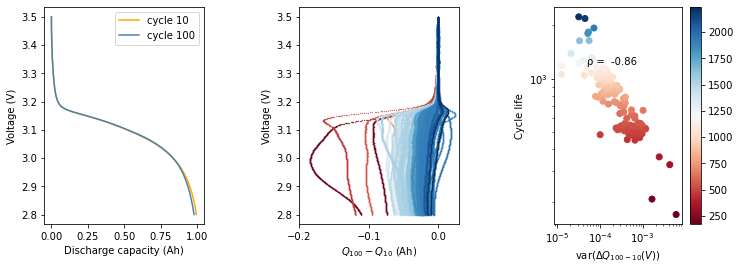

In [95]:
DQ_sorted = sorted(DeltaQ100_10, key=lambda x:x['cycle_life'].iloc[-1]) # Sort cells according to cycle life

voltage = np.linspace(2.8,3.5,1000) # Same voltage points for all cycles
var_DQ = [] # Variance(Q_100-10)
cycle_lives = []

fig, ax = plt.subplots(ncols=3, figsize=(12,4))

# Fig 2a: Qd for cycle 10 and 100
Qd10 = c10_discharge[10]['discharge_capacity'].values
Qd100 = c100_discharge[10]['discharge_capacity'].values
ax[0].plot(Qd10, voltage, color='orange', label='cycle 10')
ax[0].plot(Qd100, voltage, color='steelblue', label='cycle 100')
ax[0].set_xlabel('Discharge capacity (Ah)')
ax[0].set_ylabel('Voltage (V)', rotation='vertical')
ax[0].legend()

for i in range(len(DQ_sorted)):
    cycle_lives.append(DQ_sorted[i]['cycle_life'].iloc[-1])
    
    # Fig 2b: Difference in Qd between cycle 100 and 10
    ax[1].scatter(DQ_sorted[i]['discharge_capacity'], voltage, s=0.1, color=colors[i])
    ax[1].set_xlim(-0.2,0.03)
    ax[1].set_xticks([-0.2, -0.1, 0])
    ax[1].set_xlabel('$Q_{100} - Q_{10}$ (Ah)')
    ax[1].set_ylabel('Voltage (V)', rotation='vertical')
    
    var_DQ.append(float(np.var(DQ_sorted[i]['discharge_capacity'])))

corr_variance = np.corrcoef(np.log10(cycle_lives), np.log10(var_DQ))

# Fig 2c: var(Qd100-10) as function of cycle life
im = ax[2].scatter(var_DQ, cycle_lives, c=cycle_lives, cmap='RdBu')
fig.colorbar(im, ax=ax[2])
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel('var($\u0394Q_{100-10}(V)$)')
ax[2].set_ylabel('Cycle life')
ax[2].text(0.00005, 1200, f"\u03C1 =  {corr_variance[1,0]:.2f}")

plt.subplots_adjust(wspace=0.6)
fig.savefig(".\out\good_correlation.png")

# ML models

There are three models in the paper, with increasing amount of available features. The features can be split into three categories.

Features based on $\Delta Q_{100-10}(V)$
- f1: min$(\Delta Q_{100-10}(V))$
- f2: mean$(\Delta Q_{100-10}(V))$
- f3: var$(\Delta Q_{100-10}(V))$
- f4: skewness$(\Delta Q_{100-10}(V))$
- f5: kurtosis$(\Delta Q_{100-10}(V))$

Features based on the discharge capacity fade curves
- f6: Slope of the linear fit to the capacity fade curve, cycles 2 to 100
- f7: Intercept of the linear fit to capacity fade curve, cycles 2 to 100
- f8: Slope of the linear fit to the capacity fade curve, cycles 91 to 100
- f9: Intercept of the linear fit to capacity fade curve, cycles 91 to 100
- f10: Discharge capacity, cycle 2
- f11: Difference between max discharge capacity and cycle 2
- f12: Discharge capacity, cycle 100

Other features
- f13: Average charge time, first 5 cycles
- f14: Maximum temperature, cycles 2 to 100
- f15: Minimum temperature, cycles 2 to 100
- f16: Integral of temperature over time, cycles 2 to 100
- f17: Internal resistance, cycle 2
- f18: Minimum internal resistance, cycles 2 to 100
- f19: Internal resistance, difference between cycle 100 and cycle 2

One additional feature from the paper, the discharge capacity at 2 V, is not included here. The reason is that the voltage in this dataset only ranges from 3.6 to 2.8 V as mentioned earlier in the Notebook.

In [16]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import skew, kurtosis

#### Generate features

In [88]:
n_features = 19 # total number of features
n_targets = len(DeltaQ100_10) # number of cells/cycle lives

# Target vector with all cycle lives
y = np.zeros(n_targets)

# Design matrix
X = np.zeros((n_targets,n_features))

# Q100-10 features f1-f5
for i in range(len(DeltaQ100_10)):  
    X[i,0] = np.log10(abs(np.amin(DeltaQ100_10[i]['discharge_capacity'].values)))
    X[i,1] = np.log10(abs(np.mean(DeltaQ100_10[i]['discharge_capacity'].values)))
    X[i,2] = np.log10(float(np.var(DeltaQ100_10[i]['discharge_capacity'].values)))
    X[i,3] = np.log10(abs(skew(DeltaQ100_10[i]['discharge_capacity'].values)))
    X[i,4] = np.log10(abs(kurtosis(DeltaQ100_10[i]['discharge_capacity'].values)))

# Per cycle features
for i in range(len(summary)):
    y[i] = np.log10(summary[i].index[-1])
    
    slope100_2 = float((summary[i]['discharge_capacity'][99] - summary[i]['discharge_capacity'][1])/98) #dQd / dcycle
    slope100_91 = float((summary[i]['discharge_capacity'][99] - summary[i]['discharge_capacity'][90])/9)
    intercept100_2 = summary[i]['discharge_capacity'][9] - slope100_2*10 # b = y-mx
    intercept100_91 = summary[i]['discharge_capacity'][9] - slope100_91*10 # b = y-mx
    diff = np.amax(summary[i]['discharge_capacity'][1:-1]) - summary[i]['discharge_capacity'][1]
    
    
    X[i,5] = slope100_2
    X[i,6] = intercept100_2
    X[i,7] = slope100_91
    X[i,8] = intercept100_91
    X[i,9] = summary[i]['discharge_capacity'][1]
    X[i,10] = diff
    X[i,11] = summary[i]['discharge_capacity'][99]
    
    X[i,12] = np.mean(summary[i]['charge_duration'][1:6])
    X[i,13] = np.amax(summary[i]['temperature_maximum'][1:99])
    X[i,14] = np.amin(summary[i]['temperature_minimum'][1:99])
    X[i,15] = np.mean(summary[i]['time_temperature_integrated'][1:99])
    X[i,16] = summary[i]['dc_internal_resistance'][1]
    X[i,17] = np.amin(summary[i]['dc_internal_resistance'][1:99])
    X[i,18] = summary[i]['dc_internal_resistance'][99] - summary[i]['dc_internal_resistance'][1]

#### Create models and make predictions

In [89]:
from sklearn.pipeline import Pipeline

X_var = X[:,2].reshape(-1,1) #Shape (30,1)
X_discharge = X[:,0:12] #Shape (30,12)
X_full = X # Shape (30,19)

X_train_var, X_test_var, y_train_var, y_test_var = train_test_split(X_var, y, test_size=0.2, random_state=0)
X_train_discharge, X_test_discharge, y_train_discharge, y_test_discharge = train_test_split(X_discharge, y, test_size=0.2, random_state=0)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size=0.2, random_state=0)

# One pipeline for each model
pipe_var = Pipeline([('scaler', StandardScaler()), ('estimator', ElasticNetCV(cv=10,max_iter=10000, tol=0.0001))])
pipe_discharge = Pipeline([('scaler', StandardScaler()), ('estimator', ElasticNetCV(cv=10,max_iter=10000, tol=0.0001))])
pipe_full = Pipeline([('scaler', StandardScaler()), ('estimator', ElasticNetCV(cv=10,max_iter=10000, tol=0.0001))])

# Predictions
pipe_var.fit(X_train_var, y_train_var)
prediction_train_var = pipe_var.predict(X_train_var)
prediction_test_var = pipe_var.predict(X_test_var)

pipe_discharge.fit(X_train_discharge, y_train_discharge)
prediction_train_discharge = pipe_discharge.predict(X_train_discharge)
prediction_test_discharge = pipe_discharge.predict(X_test_discharge)

pipe_full.fit(X_train_full, y_train_full)
prediction_train_full = pipe_full.predict(X_train_full)
prediction_test_full = pipe_full.predict(X_test_full)

#### Errors metrics for each model

In [90]:
print('Variance model')
errors_var = get_errors(y_train_var,y_test_var, prediction_train_var, prediction_test_var)
errors_var_table = pd.DataFrame({'RMSE': [errors_var[0], errors_var[1]], 'RMSE CYCLES': [errors_var[2],errors_var[3]],\
                       'R2 SCORE': [errors_var[4],errors_var[5]] ,'MAPE': [errors_var[6],errors_var[7]]}, index=['train', 'test'])
display(errors_var_table)

print("\n\n")
print('Discharge model')
errors_discharge = get_errors(y_train_discharge, y_test_discharge, prediction_train_discharge, prediction_test_discharge)
errors_discharge_table = pd.DataFrame({'RMSE': [errors_discharge[0], errors_discharge[1]], 'RMSE CYCLES': [errors_discharge[2],errors_discharge[3]],\
                       'R2 SCORE': [errors_discharge[4],errors_discharge[5]] ,'MAPE': [errors_discharge[6],errors_discharge[7]]}, index=['train', 'test'])
display(errors_discharge_table)

print("\n\n")
print('Full model')
errors_discharge = get_errors(y_train_discharge, y_test_discharge, prediction_train_full, prediction_test_full)
errors_full_table = pd.DataFrame({'RMSE': [errors_full[0], errors_full[1]], 'RMSE CYCLES': [errors_full[2],errors_full[3]],\
                       'R2 SCORE': [errors_full[4],errors_full[5]] ,'MAPE': [errors_full[6],errors_full[7]]}, index=['train', 'test'])
display(errors_full_table)

Variance model


,RMSE,RMSE CYCLES,R2 SCORE,MAPE
train,0.008684,231.610358,0.702600,0.024266
test,0.006751,192.596055,0.838668,0.022311





Discharge model


,RMSE,RMSE CYCLES,R2 SCORE,MAPE
train,0.005550,177.004092,0.809923,0.018786
test,0.012582,224.257191,0.699345,0.022427





Full model


,RMSE,RMSE CYCLES,R2 SCORE,MAPE
train,0.003643,164.422152,0.881985,0.014960
test,0.007011,145.382609,0.797754,0.021013


### Plots showing linear relationship between some features and cycle life

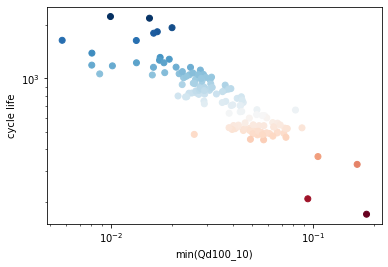

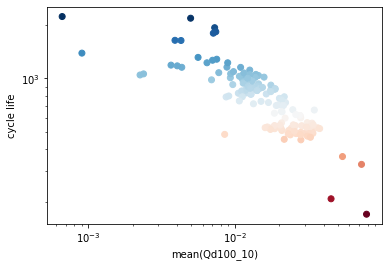

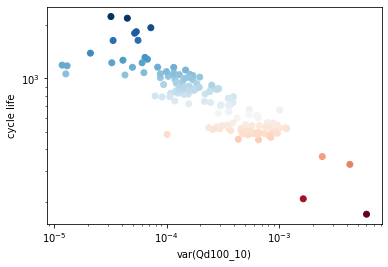

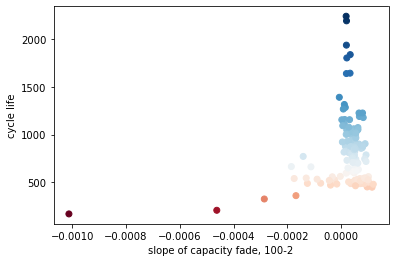

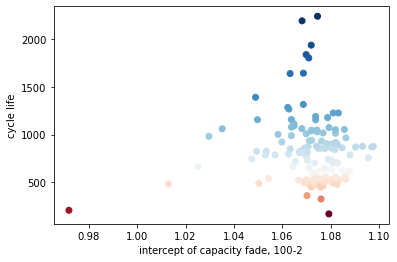

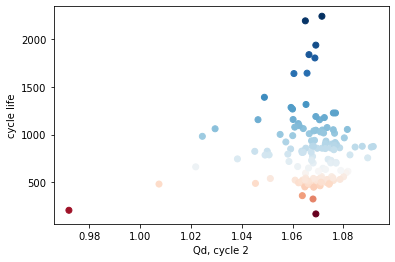

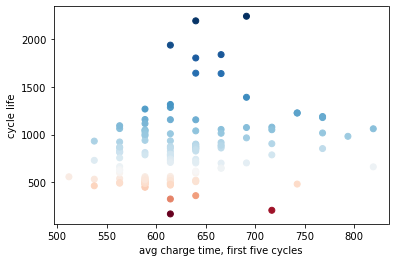

In [21]:
plt.scatter(np.power(10,X[:,0]), np.power(10,y), c=y, cmap='RdBu')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('min(Qd100_10)')
plt.ylabel('cycle life')
plt.show()

plt.scatter(np.power(10,X[:,1]), np.power(10,y), c=y, cmap='RdBu')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mean(Qd100_10)')
plt.ylabel('cycle life')
plt.show()

plt.scatter(np.power(10,X[:,2]), np.power(10,y), c=y, cmap='RdBu')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('var(Qd100_10)')
plt.ylabel('cycle life')
plt.show()

plt.scatter(X[:,5], np.power(10,y), c=y, cmap='RdBu')
#plt.yscale('log')
plt.xlabel('slope of capacity fade, 100-2')
plt.ylabel('cycle life')
plt.show()

plt.scatter(X[:,6], np.power(10,y), c=y, cmap='RdBu')
#plt.yscale('log')
plt.xlabel('intercept of capacity fade, 100-2')
plt.ylabel('cycle life')
plt.show()

plt.scatter(X[:,9], np.power(10,y), c=y, cmap='RdBu')
#plt.yscale('log')
plt.xlabel('Qd, cycle 2')
plt.ylabel('cycle life')
plt.show()

plt.scatter(X[:,12], np.power(10,y), c=y, cmap='RdBu')
#plt.yscale('log')
plt.xlabel('avg charge time, first five cycles')
plt.ylabel('cycle life')
plt.show()

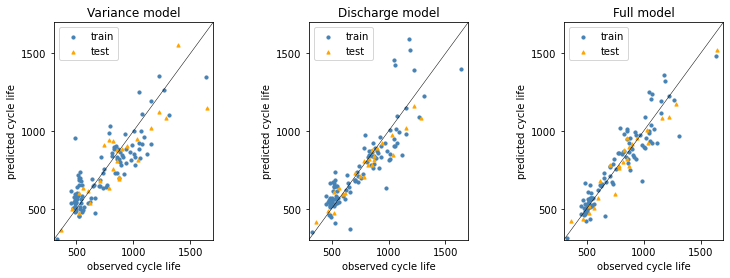

In [96]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4))

x_line = np.linspace(0,1700)
y_line = np.linspace(0,1700)

ax[0].scatter(np.power(10,y_train_var), np.power(10,prediction_train_var), color='steelblue', s=10, label='train')
ax[0].scatter(np.power(10,y_test_var), np.power(10,prediction_test_var), color='orange', marker='^', s=10, label='test')
ax[0].plot(x_line,y_line, color='black', linewidth=0.5)
ax[0].set_xlim(300,1700)
ax[0].set_ylim(300,1700)
ax[0].set_xticks([500,1000,1500])
ax[0].set_yticks([500,1000,1500])
ax[0].set_xlabel('observed cycle life')
ax[0].set_ylabel('predicted cycle life')
ax[0].legend()
ax[0].set_title('Variance model')


ax[1].scatter(np.power(10,y_train_discharge), np.power(10,discharge_pred_train), color='steelblue', s=10,label='train')
ax[1].scatter(np.power(10,y_test_discharge), np.power(10,discharge_pred_test), color='orange', marker='^', s=10, label='test')
ax[1].plot(x_line,y_line, color='black', linewidth=0.5)
ax[1].set_xlim(300,1700)
ax[1].set_ylim(300,1700)
ax[1].set_xticks([500,1000,1500])
ax[1].set_yticks([500,1000,1500])
ax[1].set_xlabel('observed cycle life')
ax[1].set_ylabel('predicted cycle life')
ax[1].legend()
ax[1].set_title('Discharge model')


ax[2].scatter(np.power(10,y_train_full), np.power(10,prediction_train_full), color='steelblue', s=10, label='train')
ax[2].scatter(np.power(10,y_test_full), np.power(10,prediction_test_full), color='orange', marker='^', s=10, label='test')
ax[2].plot(x_line,y_line, color='black', linewidth=0.5)
ax[2].set_xlim(300,1700)
ax[2].set_ylim(300,1700)
ax[2].set_xticks([500,1000,1500])
ax[2].set_yticks([500,1000,1500])
ax[2].set_xlabel('observed cycle life')
ax[2].set_ylabel('predicted cycle life')
ax[2].legend()
ax[2].set_title('Full model')

plt.subplots_adjust(wspace=0.6)
plt.show()
fig.savefig(".\out\observed_vs_predicted.png")